In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import pdb

from torch import nn

In [ ]:

class ResNet50(nn.Module):
    def __init__(self, block, num_classes=1000):
        super(ResNet50, self).__init__()
        self.block = block
        self.num_classes = num_classes

        self.stage1 = self.stage_input()
        self.stage2 = self.stage_blocks(3, 64, 64, stride=1)
        self.stage3 = self.stage_blocks(4, 64 * 4, 128, stride=2)
        self.stage4 = self.stage_blocks(6, 128 * 4, 256, stride=2)
        self.stage5 = self.stage_blocks(3, 256 * 4, 512, stride=2)
        self.stage6 = self.stage_output(512 * 4, self.num_classes)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        return x

    def stage_input(self):
        conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        bn = nn.BatchNorm2d(64)
        relu = nn.ReLU()
        pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        return nn.Sequential(conv, bn, relu, pool)

    def stage_blocks(self, n, in_channels, out_channels, stride=1):
        layers = [self.block(in_channels, out_channels, stride)]
        for i in range(n - 1):
            layers.append(self.block(out_channels * 4, out_channels))
        return nn.Sequential(*layers)

    def stage_output(self, in_channels, out_channels, stride=1):
        pool = nn.AdaptiveAvgPool2d((1, 1))
        flatten = nn.Flatten()
        fc = nn.Linear(in_channels, out_channels)
        return nn.Sequential(pool, flatten, fc)


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU()

        self.need_downsample = stride != 1 or in_channels != out_channels * 4
        if self.need_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        if self.need_downsample:
            identity = self.downsample(identity)

        out = x + identity
        out = self.relu(out)

        return out


class SEBlock(nn.Module):
    def __init__(self, channel, r):
        super().__init__()
        reductionChannel = int(channel / r)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(channel, reductionChannel)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(reductionChannel, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # pdb.set_trace()
        out = self.pool(x)
        batch, channel = out.size(0), out.size(1)
        out = out.view(batch, -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = out.view(batch, channel, 1, 1)
        out = self.sigmoid(out)
        return out


class SEResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SEResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU()

        self.need_downsample = stride != 1 or in_channels != out_channels * 4
        if self.need_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        else:
            self.downsample = None

        self.seBlock = SEBlock(out_channels * 4, 1)

    def forward(self, x):
        identity = x

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        if self.need_downsample:
            identity = self.downsample(identity)

        # apply SE
        scale = self.seBlock(x)

        out = x * scale + identity
        out = self.relu(out)

        return out

In [ ]:
se_resnet = ResNet50(SEResNetBlock)
resnet = ResNet50(ResNetBlock)

In [ ]:
batch_size = 128


In [ ]:
# Define the data transformations (optional but recommended)
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the pixel values
# ])


#Other Transforms can be used
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])



# Download CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Download CIFAR-10 testing dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create data loaders for training and testing datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 81613015.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch
import numpy as np
import random


In [ ]:
seed = 0

# Set seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set seed for NumPy
np.random.seed(seed)

# Set seed for Python's random module
random.seed(seed)

In [ ]:
se_resnet = ResNet50(SEResNetBlock)

In [ ]:
learning_rate = 0.01
epochs = 200

In [ ]:
optimizer = torch.optim.Adam(se_resnet.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
se_resnet = se_resnet.to(device)

In [ ]:
# # Training loop
# se_resnet.train()
# for epoch in range(epochs):
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = se_resnet(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# print('Training finished.')

In [14]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []


for epoch in range(epochs):
  # Training loop
  correct_predictions = 0
  total_samples = 0
  running_loss = 0.0

  se_resnet.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    #train
    optimizer.zero_grad()
    outputs = se_resnet(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #saving for loss and acc
    running_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total_samples += labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

  training_loss.append(running_loss)
  training_acc.append(correct_predictions / total_samples)

  # Testing loop
  se_resnet.eval()  # Set the model to evaluation mode
  correct_predictions = 0
  total_samples = 0
  running_loss = 0

  with torch.no_grad():

    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      # test
      outputs = se_resnet(inputs)
      loss = criterion(outputs, labels)

      #saving for loss and acc
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total_samples += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

  testing_loss.append(running_loss)
  testing_acc.append(correct_predictions / total_samples)


  print(f'Epoch {epoch + 1}/{epochs} - '
      f'Train Running Loss: {training_loss[-1]:.4f} - '
      f'Test Loss: {testing_loss[-1]:.4f} - '
      f'Test Accuracy: {testing_acc[-1]:.4f}')

print('Training finished.')

Epoch 1/200 - Train Running Loss: 956.5827 - Test Loss: 147.4199 - Test Accuracy: 0.3068
Epoch 2/200 - Train Running Loss: 696.7915 - Test Loss: 134.4298 - Test Accuracy: 0.3792
Epoch 3/200 - Train Running Loss: 616.9102 - Test Loss: 112.4671 - Test Accuracy: 0.4763
Epoch 4/200 - Train Running Loss: 560.8969 - Test Loss: 106.6757 - Test Accuracy: 0.5172
Epoch 5/200 - Train Running Loss: 519.9772 - Test Loss: 95.0207 - Test Accuracy: 0.5647
Epoch 6/200 - Train Running Loss: 487.9018 - Test Loss: 112.5931 - Test Accuracy: 0.5403
Epoch 7/200 - Train Running Loss: 450.4974 - Test Loss: 91.1793 - Test Accuracy: 0.5896
Epoch 8/200 - Train Running Loss: 421.7331 - Test Loss: 88.3565 - Test Accuracy: 0.6121
Epoch 9/200 - Train Running Loss: 399.3839 - Test Loss: 88.8995 - Test Accuracy: 0.6636
Epoch 10/200 - Train Running Loss: 364.7224 - Test Loss: 77.5614 - Test Accuracy: 0.6544
Epoch 11/200 - Train Running Loss: 358.0848 - Test Loss: 70.3603 - Test Accuracy: 0.6941
Epoch 12/200 - Train Runn

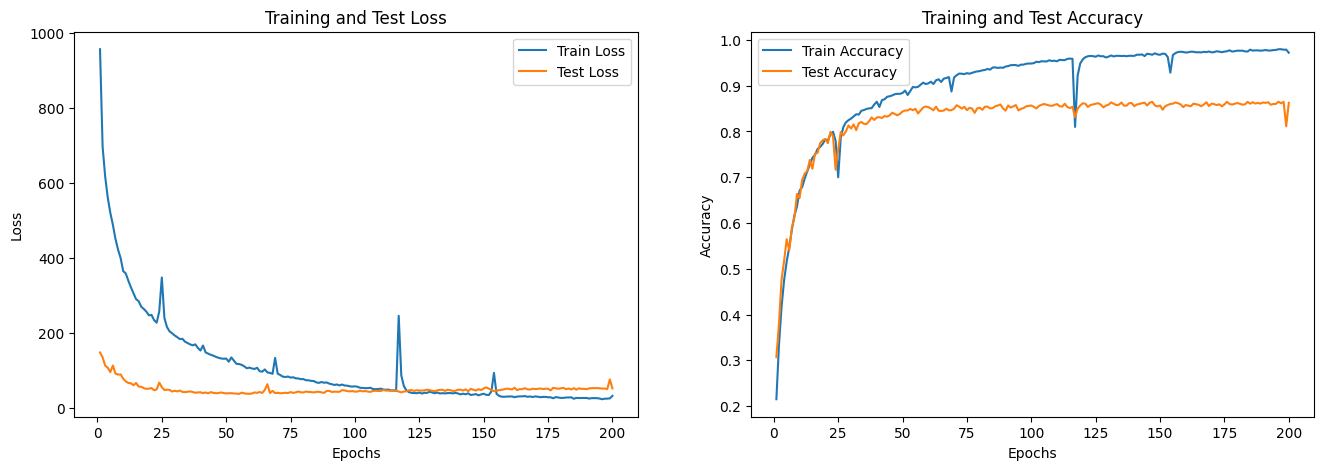

In [19]:

import matplotlib.pyplot as plt


epochs_range = range(1, len(training_loss) + 1)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_loss, label='Train Loss')
plt.plot(epochs_range, testing_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_acc, label='Train Accuracy')
plt.plot(epochs_range, testing_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

In [15]:
se_resnet.eval()  # Set the model to evaluation mode

correct_predictions = 0
total_samples = 0

with torch.no_grad():

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = se_resnet(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Update counts
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on the testing set: {accuracy * 100:.2f}%")

Accuracy on the testing set: 86.27%


In [16]:
se_resnet.eval()  # Set the model to evaluation mode

correct_predictions = 0
total_samples = 0

with torch.no_grad():

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = se_resnet(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Update counts
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on the training set: {accuracy * 100:.2f}%")

Accuracy on the training set: 98.25%


In [ ]:
pytorch_total_params = sum(p.numel() for p in se_resnet.parameters())
pytorch_total_params

In [ ]:
se_resnet

SE_ResNet\
testing set\
100 epochs, 84.37%\
200 epochs, 86.37%

training set\
200 epochs, 98.31%